# QUESTIONS
- consider adding pipelines?
- feature engineering?
- fitting transformers?
- go into detail on why DT's > log and KNN

# Final Project Submission

* Student name: Sabina Bains
* Student pace: Self Paced
* Scheduled project review date / time: 1/19/2022 @ 1 pm PCT
* Instructor name: Claude Fried

## Business Understanding

## Data Understanding

##### Reading in necessary packages

In [1]:
# Importing neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from matplotlib import style
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

style.use('dark_background')
pd.set_option("display.max_columns", 100)

##### Reading in datasets, understanding data

In [2]:
# reading in math and language datasets
mat  = pd.read_csv('data/student-mat.csv', sep=';')
lan = pd.read_csv('data/student-por.csv', sep=';')

# adding column to distiguish subject
mat['subject'] = 'Math'
lan['subject'] = 'Language'

#concatenating into one df
df = pd.concat([mat,lan])

#looking at first 5 rows
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,Math
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,Math
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,Math
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,Math
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,Math


In [3]:
# checking rows and columns
df.shape

(1044, 34)

(array([ 54.,   0.,   9.,  37., 130., 304., 216., 172.,  87.,  35.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

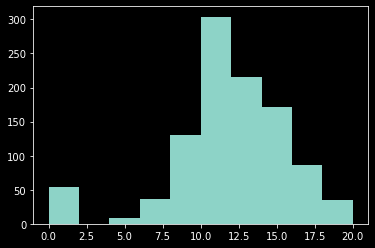

In [4]:
# Distribution of final grades
plt.hist(df.G3)

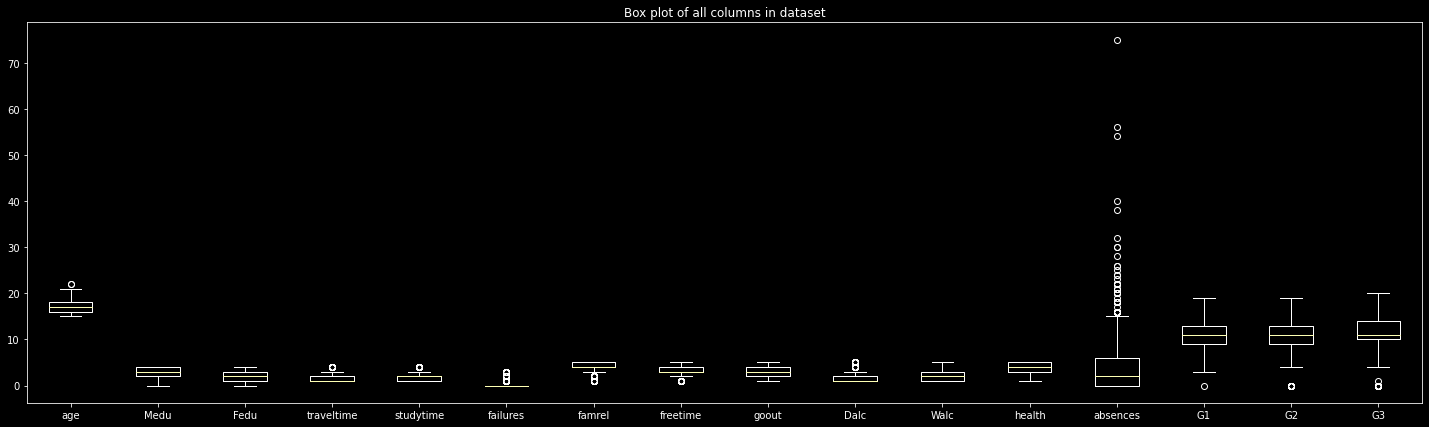

In [5]:
# Taking a look at spread for each numeric column
plt.figure(figsize=(25, 7))
plt.boxplot([df[col] for col in df.columns if df[col].dtype != 'O'])
plt.title("Box plot of all columns in dataset")
plt.xticks(range(1,17), [col for col in df.columns if df[col].dtype != 'O'])
plt.show()

## Preprocessing

##### Checking dtypes. will need to change some numeric data to string. No missing data

In [6]:
# Checking dtypes. Will need to change some numeric to str type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 648
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher   

In [7]:
# creating a list of columns to convert 
cols_to_convert = ['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup',
                   'famsup','paid','activities','nursery','higher','romantic','internet']

In [8]:
# Looping through columns that we need to convert to string
for col in cols_to_convert:
    df[col] = df [col].astype('str')

In [9]:
#Changing outcome variable to be binary based on pass/fail status. < 60% or >= 60%
def create_binary_outcome(x):
    if x >= 12:
        return 1 #Pass
    else:
        return 0 #Fail

df['final_grade'] = df['G3'].apply(create_binary_outcome)

##### Looking at distribution of outcome variable

In [10]:
# looking at the distribution of the outcome variable (pass/fail). class is balanced
balance = df.final_grade.value_counts(normalize=True)
print('Class Distribution:\nFail: ','{:0.1%}'.format(balance[0]))
print('Pass: ','{:0.1%}'.format(balance[1]))

Class Distribution:
Fail:  51.1%
Pass:  48.9%


In [11]:
# Dropping columns that are not of interest. We want this dataset to be generalized to multiple schools so don't need school type
# also dropping mid period grades and absences / failures as this is too predictive & we want to predict for the beginning of the school year
cols_to_drop = ['school','G1','G2','G3','failures','absences']
df = df.drop(cols_to_drop, axis=1)

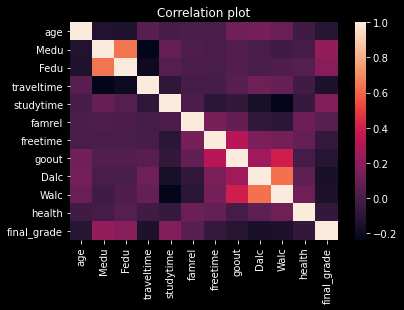

In [12]:
#correlation between features
sns.heatmap(df.corr())
plt.title("Correlation plot")
plt.show()

In [13]:
# Viewing Correlation Between Each Variable. No high correlation among features. This would only be relevant if we use a log model.
df_corr = df.corr().abs().stack().reset_index()
df_corr['preds'] = df_corr['level_0']+' & '+df_corr['level_1']
df_corr = df_corr.drop(['level_0','level_1'],axis = 1).rename(columns={0:'corr'}).sort_values(by='corr',ascending = False)
df_corr.loc[(df_corr['corr'] != 1)].head()

,corr,preds
14,0.642063,Medu & Fedu
25,0.642063,Fedu & Medu
105,0.627814,Dalc & Walc
116,0.627814,Walc & Dalc
115,0.399794,Walc & goout


##### Transforming categorical data into dummy variables

In [14]:
# Transforming categorical variables into dummies. don't need to drop first as multicollinearity is not an issue
df = pd.get_dummies(df)

In [15]:
# Splitting data into Features and Target
X = df.drop('final_grade',axis = 1)
y = df['final_grade']

In [16]:
# Train Test Split, running models on Training data to assess performance on Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

##### Creating Function to evaluate accuraty of models with less repetitive code

In [17]:
def model_eval(model,X_train,y_train,X_test,y_test,cm=False):
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    print('{} Results:'.format(model))
    print('Training Recall: ', '{:0.3%}'.format(recall_score(y_train, y_hat_train)))
    print('Testing Recall: ', '{:0.3%}\n'.format(recall_score(y_test, y_hat_test)))
    
    if cm == True:
        plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Greens)

## Modeling

##### Running First Classification Model Type  - Log Regression

LogisticRegression() Results:
Training Recall:  71.848%
Testing Recall:  69.231%


We are getting a convergence warning so we need to scale our data.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


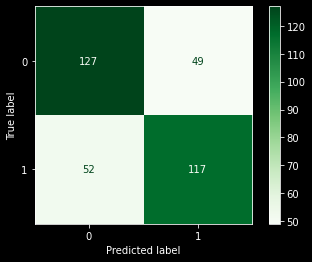

In [18]:
# Running First Model, Logistic Regression. Accounting for imbalance by calling class_weight
logreg = LogisticRegression()
model_log = logreg.fit(X_train, y_train)

model_eval(model_log,X_train,y_train,X_test,y_test, cm=True)

print('''\nWe are getting a convergence warning so we need to scale our data.''')

##### Normalizing the Data

In [19]:
# need to scale data that's why we are getting a convergence warning
scaler = StandardScaler()

#Fit and transform on the training dataset only
X_train_scaled = scaler.fit_transform(X_train)

#transfrorm only on the test dataset
X_test_scaled  = scaler.transform(X_test)

##### New Model - Log Regression with Scaled Data

In [20]:
# fitting second model with scaled data
model_log_scaled = logreg.fit(X_train_scaled, y_train)

In [21]:
# Evaluating model
model_eval(model_log_scaled, X_train_scaled, y_train, X_test_scaled, y_test)

LogisticRegression() Results:
Training Recall:  71.848%
Testing Recall:  69.822%



In [22]:
# Looks like the C value is 1.0 and solver is lbfgs, with an l2 penalty. Perhaps we can play around with these to improve the model
# Let's first look at decision trees
model_log.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

##### Modeling - Decision Trees

In [23]:
# Checking if a Decision Tree can outperform Logistic Regression:
dt = DecisionTreeClassifier()
model_dt = dt.fit(X_train, y_train)

DecisionTreeClassifier() Results:
Training Recall:  99.707%
Testing Recall:  62.722%


Training models are performing exceptionally well while the testing is low. model is severly overfitting


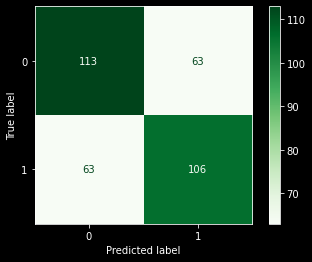

In [24]:
model_eval(model_dt, X_train, y_train, X_test, y_test, cm = True)
print('\nTraining models are performing exceptionally well while the testing is low. model is severly overfitting')

##### Modeling - Decision Tree with Pruning

In [25]:
# Pruning tree to change max_depth. this is helping increase test data and bridging gap between train and test recall. let's prune some more.
dt2 = DecisionTreeClassifier(max_depth=6)
model_dt2 = dt2.fit(X_train, y_train)

model_eval(model_dt2, X_train, y_train, X_test, y_test)

DecisionTreeClassifier(max_depth=6) Results:
Training Recall:  77.419%
Testing Recall:  62.722%



DecisionTreeClassifier(max_depth=6, min_samples_split=0.1) Results:
Training Recall:  65.982%
Testing Recall:  57.396%



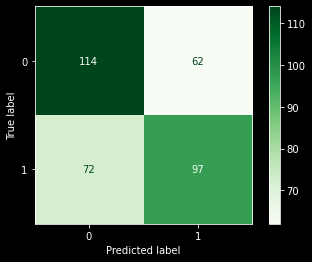

In [26]:
# changing samples_split to 0.1 further improves the model. 
dt3 = DecisionTreeClassifier(max_depth=6, min_samples_split=0.1)
model_dt3 = dt3.fit(X_train, y_train)

model_eval(model_dt3, X_train, y_train, X_test, y_test, cm = True)

In [27]:
# creating param grid to apply to DT model
dt_param_grid = {
    'criterion':['gini','entropy'],
    'max_depth':[None,5,7,8],
    'min_samples_split':[0.1,0.2,0.3],
    'min_samples_leaf':[0.1,0.2,0.3]
                }

In [28]:
# Instantiate GridSearchCV
model_dt_cv = GridSearchCV(model_dt, dt_param_grid, scoring='recall')

# Fit to the data
model_dt_cv.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 7, 8],
                         'min_samples_leaf': [0.1, 0.2, 0.3],
                         'min_samples_split': [0.1, 0.2, 0.3]},
             scoring='recall')

In [29]:
model_eval(model_dt_cv, X_train, y_train, X_test, y_test)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 7, 8],
                         'min_samples_leaf': [0.1, 0.2, 0.3],
                         'min_samples_split': [0.1, 0.2, 0.3]},
             scoring='recall') Results:
Training Recall:  71.554%
Testing Recall:  62.130%



In [30]:
model_dt_cv.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1}

##### Modeling - Random Forests

In [31]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(criterion='gini', min_samples_leaf=0.1, min_samples_split=0.1)
model_rf = forest.fit(X_train,y_train)

# Evaluate
model_eval(model_rf,X_train,y_train,X_test,y_test)

RandomForestClassifier(min_samples_leaf=0.1, min_samples_split=0.1) Results:
Training Recall:  59.824%
Testing Recall:  44.970%



In [32]:
# print("""
# The parameter tuning using GridSearchCV improved our model's performance by over 20%, from ~44% to ~66%. The model also shows no signs of overfitting, as evidenced 
# by the close training and testing scores. Grid Search does not gaurantee that we will always find the globally optimal combination of parameter values. Since 
# it only exhaustively searches through the parameter values we provide, not every possible combination of every possible value for each parameter is tested. This means 
# that the model is only as good as the possible combinations of the parameters we include in our parameter grid.
# """)

In [33]:
# When tackling overfitting, the model's recall falls to below our logistic regression model (model 1). lets go back to that and tune.
# Looking at parameters for logistic regression
model_log_scaled.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [34]:
log_param_grid = {
    'C':[1,1e2,1e3],
    'fit_intercept':[True,False],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }

In [35]:
# Instantiate GridSearchCV
log_cv = GridSearchCV(model_log_scaled, log_param_grid, scoring='recall')

# Fit to the data
log_cv.fit(X_train_scaled, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 100.0, 1000.0],
                         'fit_intercept': [True, False],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='recall')

In [36]:
log_cv.best_params_

{'C': 1, 'fit_intercept': False, 'solver': 'newton-cg'}

In [37]:
model_eval(log_cv, X_train_scaled, y_train, X_test_scaled, y_test)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 100.0, 1000.0],
                         'fit_intercept': [True, False],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='recall') Results:
Training Recall:  74.487%
Testing Recall:  70.414%



In [38]:
# looking up the best K for KNN
def find_best_k(X_train_scaled, y_train, X_test_scaled, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0
    for i in range(min_k,max_k+1, 2):
        clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(X_train_scaled,y_train)
        test_preds = clf.predict(X_test_scaled)
        score = recall_score(y_test,test_preds)
        if score > best_score:
            best_score = score
            best_k = i     
    return best_k

In [39]:
best_k = find_best_k(X_train_scaled, y_train, X_test_scaled, y_test)

In [40]:
# Taking a look at KNN models to compare
knn = KNeighborsClassifier(n_neighbors = best_k)

# fitting classifier
model_knn = knn.fit(X_train_scaled, y_train)

# predicting on scaled set
model_eval(model_knn,X_train_scaled,y_train,X_test_scaled,y_test)

KNeighborsClassifier(n_neighbors=19) Results:
Training Recall:  76.833%
Testing Recall:  72.781%



LogisticRegression() Results:
Training Recall:  71.848%
Testing Recall:  69.822%

DecisionTreeClassifier() Results:
Training Recall:  99.707%
Testing Recall:  62.722%

tuned models: 

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 7, 8],
                         'min_samples_leaf': [0.1, 0.2, 0.3],
                         'min_samples_split': [0.1, 0.2, 0.3]},
             scoring='recall') Results:
Training Recall:  0.000%
Testing Recall:  0.000%

RandomForestClassifier(min_samples_leaf=0.1, min_samples_split=0.1) Results:
Training Recall:  59.824%
Testing Recall:  44.970%

KNeighborsClassifier(n_neighbors=19) Results:
Training Recall:  76.833%
Testing Recall:  72.781%

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 100.0, 1000.0],
                         'fit_intercept': [True, False],
                         'solver': ['newton-cg', 'lbfgs', 

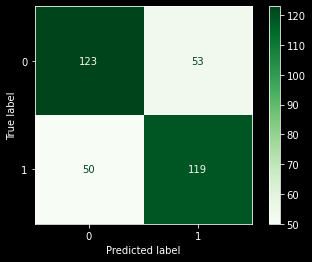

In [44]:
model_eval(model_log_scaled,X_train_scaled,y_train,X_test_scaled, y_test)
model_eval(model_dt,X_train,y_train,X_test, y_test)
print('tuned models: \n')
model_eval(model_dt_cv,X_train_scaled,y_train, X_test_scaled, y_test)
model_eval(model_rf,X_train,y_train,X_test, y_test)
model_eval(model_knn,X_train_scaled,y_train, X_test_scaled, y_test)
model_eval(log_cv,X_train_scaled,y_train, X_test_scaled, y_test, cm=True)

## Model Evaluation

## Beginning Deployment